<a href="https://colab.research.google.com/github/TanDuong986/Detect_Order/blob/master/ImageProcessing_find_order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/tan_drive')

Mounted at /content/tan_drive


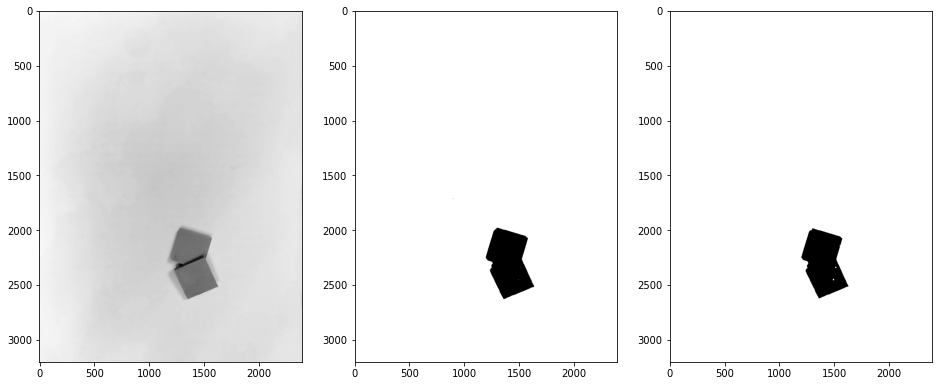

In [ ]:
sp_path = "/content/tan_drive/MyDrive/Sample_IP/cc/v_v_3.jpg"
img_name = "/content/tan_drive/MyDrive/Sample_IP/result/"+"7.jpg"
img = cv2.imread(sp_path) #15 vuong tren tron, 12 tron tren vuong, 10 vuong tren vuong
# /content/tan_drive/MyDrive/Transfer file iphone2cpt/IMG_8615.JPG


h, w = int(img.shape[0]), int(img.shape[1])

ratio = w/h
start_point =(600,600) #x,y
h_cut = 3200

# start_point =(540,640) #x,y
# h_cut = 3200

img = img[start_point[1]:start_point[1]+h_cut,start_point[0]:start_point[0]+int(h_cut*ratio)] # cut follow y:y+h,x:x+w
# img = cv2.resize(img, (w//4,h//4))
use = cv2.medianBlur(img.copy(),15)
shifted = cv2.pyrMeanShiftFiltering(img, 10,25)
ret1,th1 = cv2.threshold(shifted[...,0],160,255,cv2.THRESH_BINARY)
kernel = np.ones((5,5),np.uint8)
dialate = cv2.dilate(th1,kernel,iterations = 2)
erosion = cv2.erode(dialate,kernel,iterations = 2)
closing = cv2.morphologyEx(dialate, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(shifted[...,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(th1,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(closing,cmap='gray')

In [ ]:
# edged = cv2.Canny(closing, 30, 200) #test to take threshold for overlap contour
# contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# t = shifted.copy()
# cv2.drawContours(t, contours, -1, (0, 255, 0), 3)
# plt.imshow(cv2.cvtColor(t,cv2.COLOR_BGR2RGB))
# for c in contours:
#   print(cv2.contourArea(c))

def check_overlap(thresh,C = 14000 ):
  edged = cv2.Canny(thresh, 30, 200)
  cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  return cv2.contourArea(c) > C

def find_csd(ctr):
  m = ctr[0][0]
  id_m =0
  for i in range(len(ctr)):
    if ctr[i][0] > m :
      m = ctr[i][0]
      id_m = i
  return id_m

def find_order(shifted,ctr):
  offset = -60
  d = (np.sqrt(2)/2)*ctr[index][2]
  tl = (int(ctr[index][0]-d-offset),int(ctr[index][1]-d-offset))
  rb = (int(ctr[index][0]+d+offset),int(ctr[index][1]+d+offset))

  consider = shifted[tl[1]:rb[1],tl[0]:rb[0]]
  consider = cv2.GaussianBlur(consider,(7,7),None)
  cny =cv2.Canny(consider[...,0],20,100)
  plt.imshow(consider,cmap='gray')
  # print(tl,rb)
  ctt, hierarchy = cv2.findContours(cny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return (len(ctt) == 0) #return True when consider lying on top


<ipython-input-8-c5336ab39ee6>:2: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=80, labels=255-closing) # find each local maximum (center)


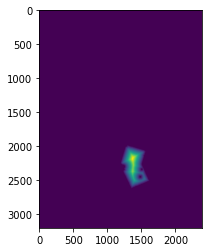

In [ ]:
D = ndimage.distance_transform_edt(255-closing)  # compute matrix distance to correlate peak
localMax = peak_local_max(D, indices=False, min_distance=80, labels=255-closing) # find each local maximum (center)
plt.imshow(D.astype(np.uint8))
print(closing.shape)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm

# markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0] #use to make connect between pixel and label to object
# labels = watershed(-D, markers, mask=255-closing)
# print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
# plt.figure(figsize=(8,12))
# plt.imshow(labels, cmap=plt.cm.nipy_spectral)

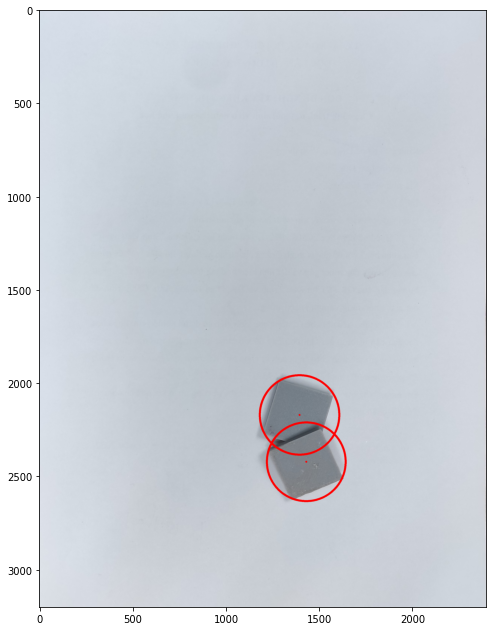

In [ ]:
# loop over the unique labels returned by the Watershed
dp = img.copy()
ctr = []
# algorithm
for label in np.unique(labels):
  # if the label is zero, we are examining the 'background'
  # so simply ignore it
  if label == 0:
    continue
  # otherwise, allocate memory for the label region and draw
  # it on the mask
  mask = np.zeros(shifted[...,0].shape, dtype="uint8")
  mask[labels == label] = 255
  # detect contours in the mask and grab the largest one
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # draw a circle enclosing the object
  ((x, y), r) = cv2.minEnclosingCircle(c)
  ctr.append((x,y,r))
  cv2.circle(dp, (int(x), int(y)), 5, (0, 0, 255), -1)
  cv2.circle(dp,(int(x), int(y)),int(r),(0, 0, 255),10)
  # cv2.rectangle(dp,(int(x-r), int(y-r)),(int(x+r), int(y+r)),(0,255,0),1)
  # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(dp,cv2.COLOR_BGR2RGB))

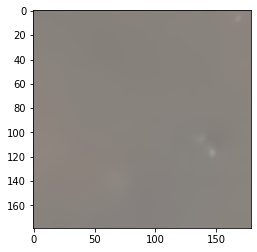

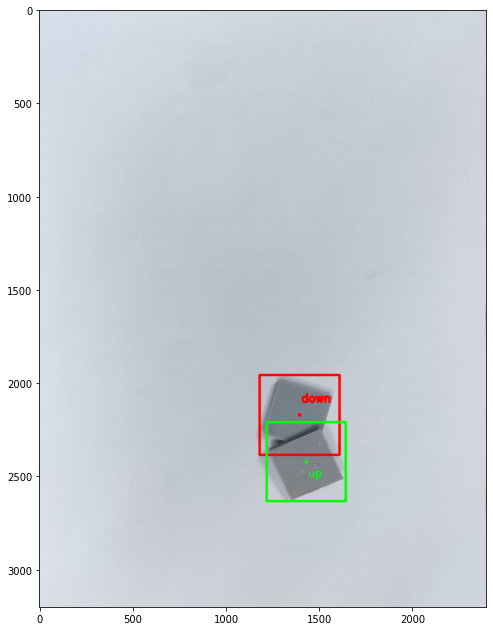

In [ ]:
index = find_csd(ctr)
if check_overlap(closing):
  # tt= shifted.copy()
  # d = (np.sqrt(2)/2)*ctr[index][2]
  # tl = (int(ctr[index][0]-d-offset),int(ctr[index][1]-d-offset))
  # rb = (int(ctr[index][0]+d+offset),int(ctr[index][1]+d+offset))
  # cv2.rectangle(tt,tl,rb,(0,255,0),3)
  # plt.figure(figsize = (12,16))
  # plt.imshow(cv2.cvtColor(tt,cv2.COLOR_BGR2RGB))
  od = find_order(shifted,ctr)
  order = [0,0]
  order[index] = od
  order[-1-index] = not(od)
  dpp = img.copy()
  for i in range(2) :
    if order[i] == True:
      cv2.circle(dpp, (int(ctr[i][0]), int(ctr[i][1])), 10, (0, 255, 0), -1)
      cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,255,0),12)
      cv2.putText(dpp,"up" , (int(ctr[i][0]) + 10, int(ctr[i][1])+80),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
    else:
      cv2.circle(dpp, (int(ctr[i][0]), int(ctr[i][1])), 10, (0, 0, 255), -1)
      cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,0,255),12)
      cv2.putText(dpp,"down" , (int(ctr[i][0]) + 10, int(ctr[i][1])-70),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 12)
  plt.figure(figsize = (8,12))
  plt.imshow(cv2.cvtColor(dpp,cv2.COLOR_BGR2RGB))

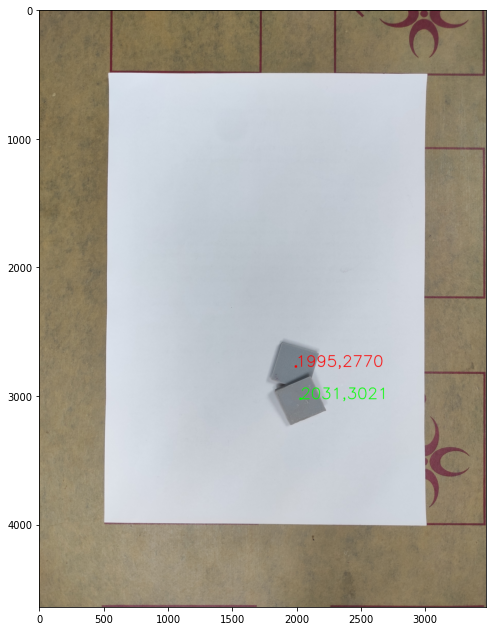

In [ ]:
img = cv2.imread(sp_path)
if check_overlap(closing):
  dpp = img.copy()
  new_ct = []
  for i in range(2) :
    n_x = int(ctr[i][0]+ start_point[0])
    n_y = int(ctr[i][1]+ start_point[1])
    new_ct.append((n_x,n_y))
    if order[i] == True:
      cv2.circle(dpp, (n_x, n_y), 10, (0, 255, 0), -1)
      # cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,255,0),4)
      cv2.putText(dpp,str(n_x)+","+str(n_y) , (n_x, n_y),cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 6)
    else:
      cv2.circle(dpp, (n_x, n_y), 10, (0, 0, 255), -1)
      # cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,0,255),4)
      cv2.putText(dpp,str(n_x)+","+str(n_y) , (n_x, n_y),cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 6)
  plt.figure(figsize = (8,12))
  cv2.imwrite(img_name,dpp)
  plt.imshow(cv2.cvtColor(dpp,cv2.COLOR_BGR2RGB))